# **Toxic Comment Classification Challenge**

Identify and classify toxic online comments.

> [**Kaggle Dataset**](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

In [ ]:
# Install Kaggle.
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# Files Upload.
from google.colab import files

files.upload()

In [ ]:
# Create a Kaggle Folder.
!mkdir ~/.kaggle

# Copy the kaggle.json to the folder created.
!cp kaggle.json ~/.kaggle/

# Permission for the json file to act.
!chmod 600 ~/.kaggle/kaggle.json

# List all datasets in Kaggle.
!kaggle datasets list

In [ ]:
# Dataset Download.
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

In [ ]:
# Unzip Dataset.
!unzip jigsaw-toxic-comment-classification-challenge.zip

In [ ]:
# Unzip all Files.
!unzip sample_submission.csv.zip
!unzip test.csv.zip
!unzip test_labels.csv.zip
!unzip train.csv.zip

## **Toxic Comment Classification using BERT.**

In [ ]:
!pip install transformers
!pip install bert-tensorflow

In [ ]:
# Import Library.
import pandas as pd
import numpy as np
import re, string
from tqdm import tqdm
import seaborn as sns

%config InlineBackend.figure_format = "retina"
sns.set()
import warnings

warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import transformers, bert.tokenization
from tokenizers import BertWordPieceTokenizer

In [ ]:
# Load Dataset.
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# TPU Detection - Check if TPU is running or not.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU", tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)  # Connection of TPU.
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS:", strategy.num_replicas_in_sync)

## **Exploratory Data Analysis.**

Exploratory Data Analysis (EDA) is an approach to analyzing the data using visual techniques. EDA discovers trends and patterns or checks assumptions with the help of statistical summaries and graphical representations.

In [ ]:
# Dataset Shape.
print(train.shape, test.shape)

In [ ]:
# Check Missing Values.
train.isnull().sum()

In [ ]:
# Split Dataset into Feature and Target Set.
X = train.comment_text
y = train.drop(["id", "comment_text"], axis=1)

LABELS = train.columns.tolist()[2:]

In [ ]:
# Distribution of the target variable.
for i in list(y.columns):
    print("Percent of {0}s: ".format(i), round(100 * y[i].mean(), 2), "%")

Percent of toxics:  9.58 %
Percent of severe_toxics:  1.0 %
Percent of obscenes:  5.29 %
Percent of threats:  0.3 %
Percent of insults:  4.94 %
Percent of identity_hates:  0.88 %


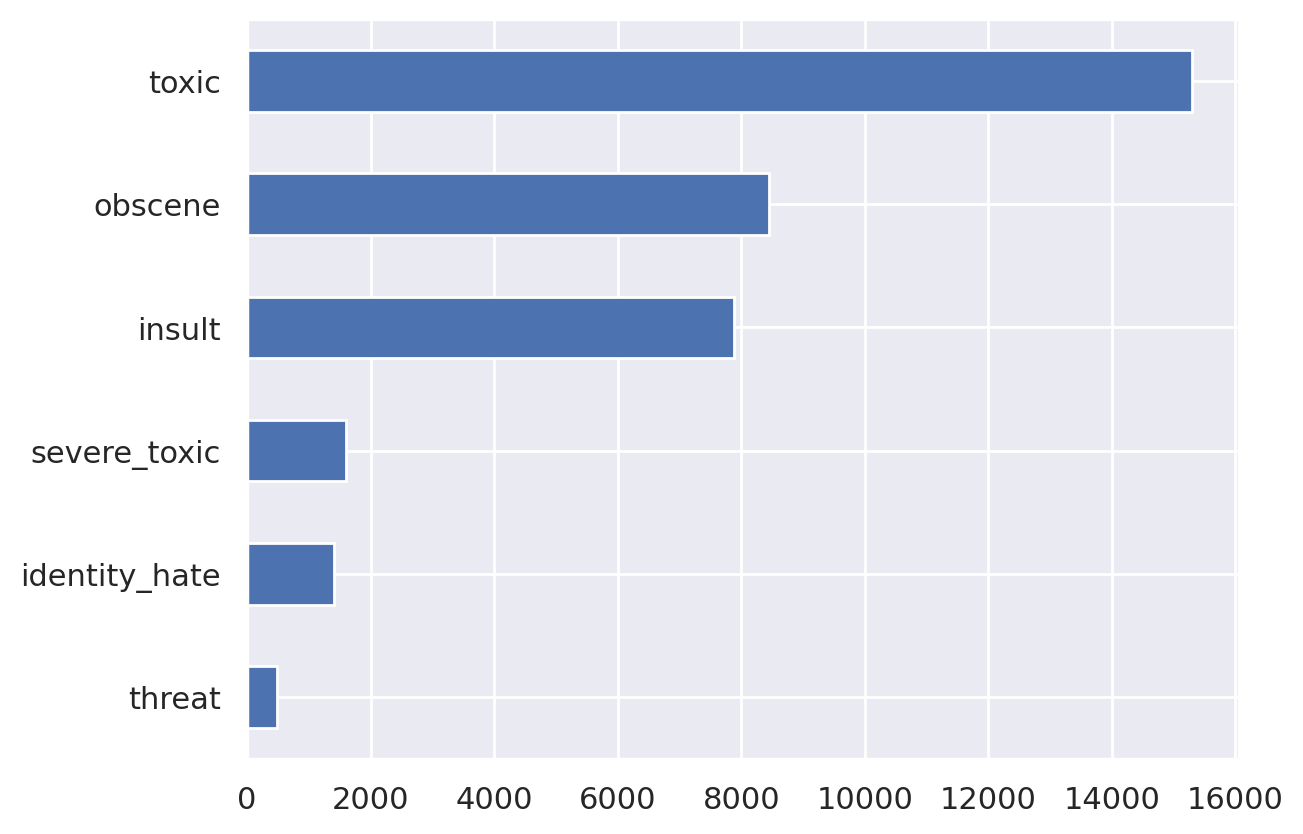

In [ ]:
# Visualization of toxic comments distributions.
train[LABELS].sum().sort_values().plot(kind="barh");

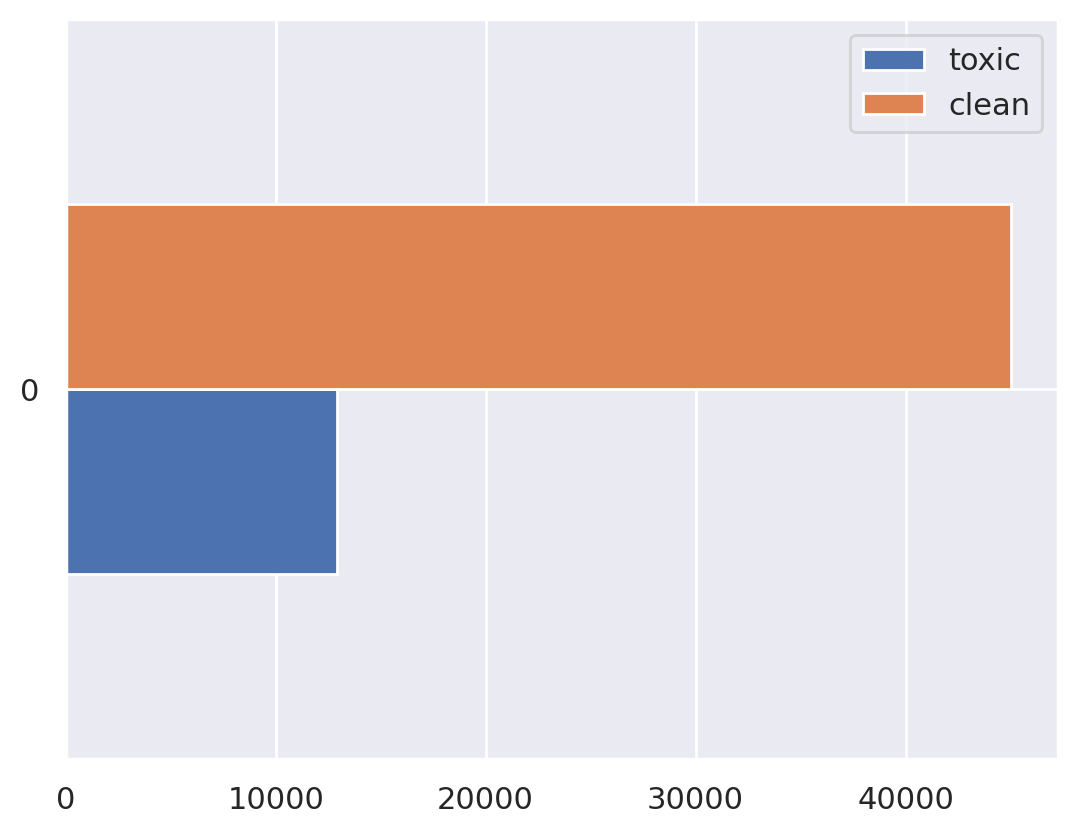

In [ ]:
# Undersample the Majority Class.
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train, test_size=0.2)

train_toxic = train_df[train_df[LABELS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABELS].sum(axis=1) == 0]

pd.DataFrame(
    dict(toxic=[len(train_toxic)], clean=[len(train_clean.sample(45_000))])
).plot(kind="barh")

# Balance dataset of Toxic and Non-toxic comments.
train_df = pd.concat([train_toxic, train_clean.sample(45_000)])

## **Text Preprocessing & Cleaning.**

Function to clean the review text and remove all the unnecessary elements.

In [ ]:
# Text Preprocessing & Cleaning.
def clean_review_text(text):
    text = text.lower()  # Convert text to lowercase.
    text = re.sub("<.*?>", "", text).strip()  # Remove HTML chars.
    text = text.translate(
        str.maketrans("", "", string.punctuation)
    )  # Remove punctuation marks.
    text = re.sub("(\\W)", " ", text).strip()  # Remove NON-ASCII chars.
    text = re.sub("\S*\d\S*\s*", "", text).strip()  # Remove words containing numbers.
    return text.strip()


# Apply Text Preprocessing.
train_df.comment_text = train_df.comment_text.astype(str)
train_df.comment_text = train_df.comment_text.apply(clean_review_text)

valid_df.comment_text = valid_df.comment_text.astype(str)
valid_df.comment_text = valid_df.comment_text.apply(clean_review_text)

test.comment_text = test.comment_text.astype(str)
test.comment_text = test.comment_text.apply(clean_review_text)

## **Toxic Comment Detector Classifier.**

Detect whether the input text is toxic or not.

In [ ]:
# Encoder to encode text into a sequence of integers for BERT input.
def fast_encode(texts, tokenizer, batch_size=256, MAX_LEN=512):
    tokenizer.enable_truncation(max_length=MAX_LEN)
    tokenizer.enable_padding(length=MAX_LEN)
    all_ids = []
    for i in tqdm(range(0, len(texts), batch_size)):
        text_chunk = texts[i : i + batch_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    return np.array(all_ids)


# Model Configuration.
AUTO = tf.data.experimental.AUTOTUNE
EPOCHS = 15
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
NO_CLASSES = len(train.columns.tolist()[2:])
MAX_LEN = 512

callbacks = [
    EarlyStopping(patience=2, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint("toxic_detector.h5", verbose=1, save_best_only=True),
]


# Model Architecture/Pipeline.
def create_model(transformer, maxlen):
    # Pretrained BERT Model.
    input_word_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]  # Output from the BERT Model.
    cls_token = sequence_output[:, 0, :]
    # Fine-Tuning BERT Model.
    out = Dense(256, activation="relu", kernel_regularizer="l2")(cls_token)
    out = Dropout(0.4)(out)
    out = Dense(128, activation="relu", kernel_regularizer="l2")(out)
    out = Dropout(0.4)(out)
    out = Dense(128, activation="relu", kernel_regularizer="l2")(out)
    out = Dropout(0.4)(out)
    out = Dense(NO_CLASSES, activation="sigmoid")(out)
    # Final Model Construction.
    model = Model(inputs=input_word_ids, outputs=out)
    # Compile the Model.
    model.compile(Adam(lr=1e-5), loss="binary_crossentropy", metrics=["AUC"])
    return model


# Load DistilBERT with the Tokenizer.
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-cased")
# Save the loaded tokenizer locally.
tokenizer.save_pretrained(".")
# Reload it with the HuggingFace tokenizers library.
fast_tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=False)

In [ ]:
# Prepare Dataset for BERT Model.
X_train = fast_encode(train_df.comment_text.astype(str), fast_tokenizer, MAX_LEN)
y_train = train_df.drop(["id", "comment_text"], axis=1)

X_valid = fast_encode(valid_df.comment_text.astype(str), fast_tokenizer, MAX_LEN)
y_valid = valid_df.drop(["id", "comment_text"], axis=1)

X_test = fast_encode(test.comment_text.astype(str), fast_tokenizer, MAX_LEN)

# Build Dataset Objects.
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(BATCH_SIZE)

In [ ]:
# Load Model into the TPU.
with strategy.scope():
    transformer_layer = transformers.TFDistilBertModel.from_pretrained(
        "distilbert-base-cased"
    )
    model = create_model(transformer_layer, MAX_LEN)

# Model Summary.
model.summary()

In [ ]:
""" Train the BERT Model. """
n_steps = X_train.shape[0] // BATCH_SIZE

# Fit the Model.
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
)

## **Predict Test Result.**

In [ ]:
# Toxic Comment Prediction.
y_pred = np.round_(model.predict(test_dataset, verbose=1), decimals=2)

result = pd.DataFrame(
    y_pred,
    columns=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"],
)

# Concatenate DataFrames.
id = test["id"]
result = pd.concat([id, result], axis=1)

# Save Predictions.
result.to_csv("submission.csv", index=False)